In [1]:
# standard libary and settings
import os
import sys

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    KFold,
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
)
from sklearn.svm import SVC, SVR
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, BinaryEncoder, CountEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.data import titanic
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldEncoder,
        GroupbyImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style

c:\programdata\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import mlmachine as mlm
from mlmachine.data import titanic

df_train, df_valid = titanic()

ordinal_encodings = {"Pclass": [1, 2, 3]}

mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

### impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked"])
    )),
])

mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)

### encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### impute pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]), 
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### scale values
scale = PandasTransformer(RobustScaler())

mlmachine_titanic_train.data = scale.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = scale.transform(mlmachine_titanic_valid.data)

>>> category label encoding

	0 --> 0
	1 --> 1



In [3]:
estimators = [
    LogisticRegression,
    XGBClassifier,
]

fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    sequential_scoring="accuracy",
    sequential_n_folds=0,
    save_to_csv=True,
)

In [4]:
feature_selector_summary

,f_value,p_value,variance,correlation_to_target,LogisticRegression_rfe_rank,XGBClassifier_rfe_rank,XGBClassifier_feature_importance,LogisticRegression_SFS_rank_accuracy_score,XGBClassifier_SFS_rank_accuracy_score,LogisticRegression_SBS_rank_accuracy_score,XGBClassifier_SBS_rank_accuracy_score
Age,4.525865,3.366090e-02,1.009266,0.071170,8,6,0.026672,6,4,28,28
Age_binned_5,3.352417,6.744099e-02,0.511785,0.061293,20,28,0.000000,11,7,2,7
Age_binned_5_catboost_encoded,1.150752,2.836829e-01,0.511604,0.035955,28,17,0.019940,12,19,17,17
Age_binned_5_target_encoded,0.214684,6.432337e-01,0.679030,0.015538,12,4,0.030045,8,5,10,4
Age_binned_5_woe_encoded,2.641617,1.044520e-01,0.691941,0.054430,24,15,0.036927,10,12,18,9
Embarked_Q,0.011846,9.133532e-01,0.078951,0.003650,21,26,0.000000,4,13,7,23
Embarked_Q_catboost_encoded,14.101688,1.844556e-04,1.871835,0.124959,15,9,0.035686,9,10,6,18
Embarked_Q_target_encoded,9.628376,1.976504e-03,2.045540,0.103511,17,8,0.028310,7,11,4,16
Embarked_Q_woe_encoded,8.220109,4.240755e-03,2.762083,0.095717,26,21,0.013490,5,18,23,11
Embarked_S,20.374460,7.223241e-06,0.199362,0.149683,4,3,0.035629,22,21,12,24


In [5]:
rf2 = RandomForestClassifier(max_depth=2)
rf4 = RandomForestClassifier(max_depth=4)
rf6 = RandomForestClassifier(max_depth=6)

estimators = [
    RandomForestClassifier,
    rf2,
    rf4,
    rf6,
]

fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    sequential_scoring="roc_auc",
    sequential_n_folds=0,
    save_to_csv=True,
)

In [6]:
feature_selector_summary

,f_value,p_value,variance,correlation_to_target,RandomForestClassifier_rfe_rank,rf2_rfe_rank,rf4_rfe_rank,rf6_rfe_rank,RandomForestClassifier_feature_importance,rf2_feature_importance,rf4_feature_importance,rf6_feature_importance,RandomForestClassifier_SFS_rank_roc_auc_score,rf2_SFS_rank_roc_auc_score,rf4_SFS_rank_roc_auc_score,rf6_SFS_rank_roc_auc_score,RandomForestClassifier_SBS_rank_roc_auc_score,rf2_SBS_rank_roc_auc_score,rf4_SBS_rank_roc_auc_score,rf6_SBS_rank_roc_auc_score
Age,4.525865,3.366090e-02,1.009266,0.071170,3,10,8,6,0.081464,0.012833,0.035976,0.049876,2,3,4,4,2,3,3,2
Age_binned_5,3.352417,6.744099e-02,0.511785,0.061293,21,27,26,22,0.019001,0.000000,0.006791,0.010984,5,4,24,13,25,14,23,12
Age_binned_5_catboost_encoded,1.150752,2.836829e-01,0.511604,0.035955,15,23,24,18,0.027582,0.001279,0.007161,0.018509,4,20,16,12,5,13,10,20
Age_binned_5_target_encoded,0.214684,6.432337e-01,0.679030,0.015538,8,20,14,11,0.036348,0.001698,0.014926,0.022717,10,11,6,9,9,5,6,5
Age_binned_5_woe_encoded,2.641617,1.044520e-01,0.691941,0.054430,10,24,19,15,0.028527,0.000000,0.009335,0.018982,15,6,14,6,15,12,19,22
Embarked_Q,0.011846,9.133532e-01,0.078951,0.003650,28,28,28,28,0.002199,0.000086,0.001252,0.001422,7,12,18,11,18,26,27,15
Embarked_Q_catboost_encoded,14.101688,1.844556e-04,1.871835,0.124959,25,17,23,23,0.013435,0.000000,0.006910,0.010506,17,8,27,18,4,24,20,13
Embarked_Q_target_encoded,9.628376,1.976504e-03,2.045540,0.103511,19,25,15,19,0.026456,0.000000,0.006323,0.016318,6,22,17,21,8,11,15,24
Embarked_Q_woe_encoded,8.220109,4.240755e-03,2.762083,0.095717,23,22,16,24,0.014282,0.002239,0.005035,0.012278,18,19,11,27,22,16,17,11
Embarked_S,20.374460,7.223241e-06,0.199362,0.149683,27,19,27,27,0.005640,0.000983,0.004617,0.001983,11,18,23,15,26,28,12,17


In [7]:
feature_selector_summary = fs.feature_selector_stats(feature_selector_summary)

In [8]:
cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
    estimators=estimators,
    scoring="accuracy",
    n_folds=5,
    step=1,
    n_jobs=4,
    save_to_csv=True,
)

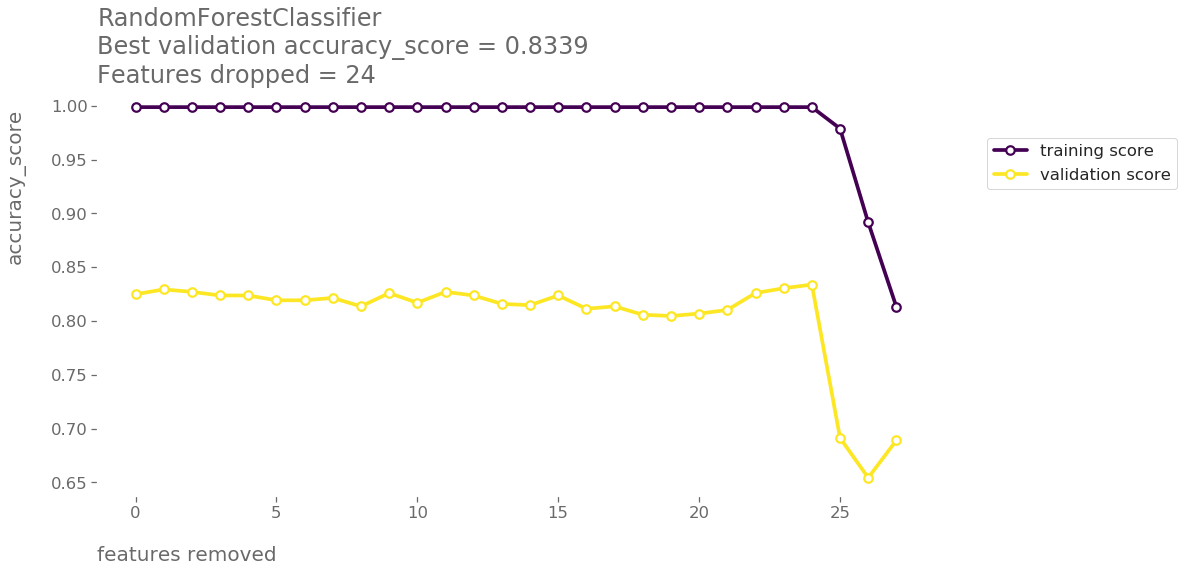

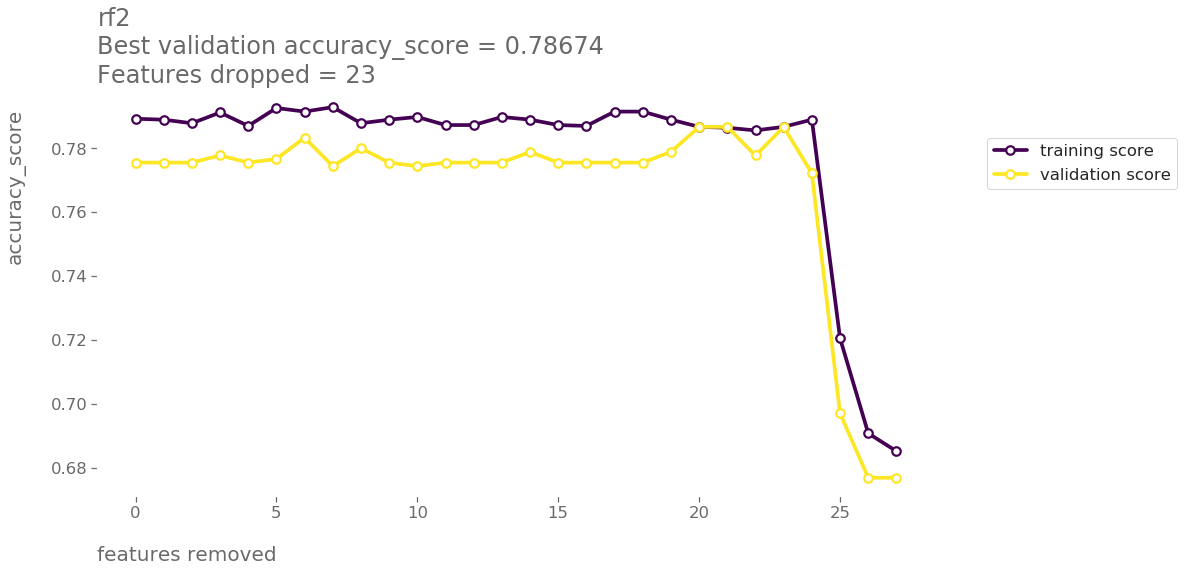

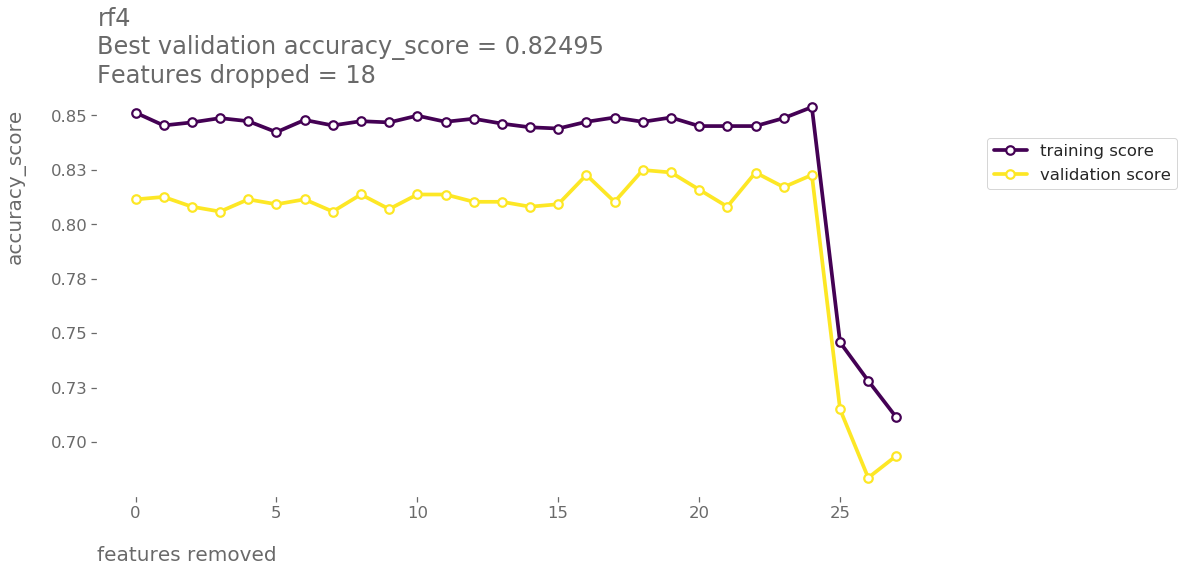

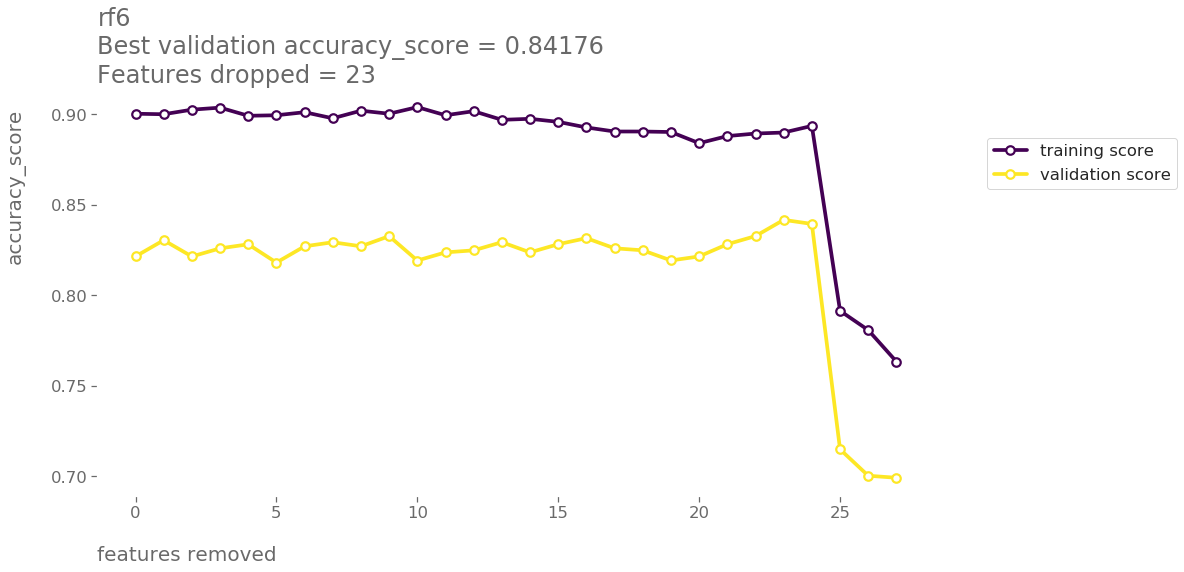

In [9]:
fs.feature_selector_results_plot(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
    title_scale=0.8,
    marker_on=True,
)

In [10]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

In [ ]:
cross_val_features_df

In [11]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

In [ ]:
cross_val_features_dict